In [1]:
'''
Nicole Osayande
261042925
Bzdok Lab MILA
'''
import os
import aesara
import scipy as sp
import arviz as az
import numpy as np
import pymc3 as pm
import pandas as pd
import xarray as xr
import seaborn as sns
from theano import shared
import arviz.labels as azl
from scipy.stats import zscore
from theano import tensor as tt
import matplotlib.pyplot as plt
from sklearn.metrics import r2_score
from sklearn.preprocessing import StandardScaler

In [2]:
#investigating crystallized cognition and neighbourhood poverty threshold
data = pd.read_csv('/Users/nicoleosa/Documents/ABCD_data/abcd_nda3_manuscript.csv', usecols=['nihtbx_cryst_uncorrected','reshist_addr1_adi_b138','abcd_site','site_id_l','race_ethnicity'], index_col=False)
print(data.shape)

(10843, 5)


In [3]:
val=data['reshist_addr1_adi_b138'].median()
data.loc[data['reshist_addr1_adi_b138'] <= val, 'reshist_addr1_adi_b138_bin'] = 0
data.loc[data['reshist_addr1_adi_b138'] > val, 'reshist_addr1_adi_b138_bin'] = 1

In [4]:
data['nihtbx_cryst_uncorrected_log']= np.log(data['nihtbx_cryst_uncorrected']) #natural logarithm to fix skew-tailed data
col='nihtbx_cryst_uncorrected_log'
data['nihtbx_cryst_uncorrected_zscore'] = (data[col] - data[col].mean())/data[col].std(ddof=0) #standardization

In [5]:
race_idxs, race = pd.factorize(data.race_ethnicity)
data['race_enc'] = race_idxs #for shared object

state_idxs, state = pd.factorize(data.site_id_l)
data['state_enc'] = state_idxs #for shared object

In [7]:
#get input variables for shared object
abcd_race = data.race_enc.values
abcd_state = data.state_enc.values
pov = data.reshist_addr1_adi_b138_bin.values
target_values = data.nihtbx_cryst_uncorrected_zscore.values

In [8]:
#initialize shared objects for the model hierarchies and input variable 
abcd_race_ = shared(abcd_race)
abcd_state_ = shared(abcd_state)
pov_ = shared(pov)

In [9]:
#varying intercepts and varying slopes: 
#predicting crystallized cognition scores from neighbourhood poverty threshold

RANDOM_SEED = 8924
np.random.seed(286)

coords = {"abcd_race": np.arange(len(race)),"abcd_state": np.arange(len(state))}


with pm.Model(coords=coords) as varying_intercept_slope:
    
    # Hyperparameters
    a = pm.Normal("a", mu=0.0, sigma=5.0)
    sigma_a = pm.Exponential("sigma_a", 1.0)
    b = pm.Normal("b", mu=0.0, sigma=1.0)
    sigma_b = pm.Exponential("sigma_b", 0.5) 
   
    # Varying intercepts
    a_state = pm.Normal("a_state", mu=0.0, sigma=1.0, dims ='abcd_state')

    # Varying slopes
    b_race = pm.Normal("b_race", mu=0.0, sigma=1.0, dims ='abcd_race')
    

    # Expected value per city, theta
    # Non-centered reparameterization 
    theta = (a + a_state[abcd_state_] * sigma_a) + (b + b_race[abcd_race_] * sigma_b) * pov_
    
    # Model error:
    sigma = pm.Exponential("sigma", 1.0)

    likelihood = pm.Normal("likelihood", theta, sigma=sigma, observed=target_values)
    
with varying_intercept_slope:
    varying_intercept_slope_idata = pm.sample(2000,
        tune=3000, init="adapt_diag", target_accept=0.99, random_seed=RANDOM_SEED, return_inferencedata=True)

Auto-assigning NUTS sampler...
Initializing NUTS using adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [sigma, b_race, a_state, sigma_b, b, sigma_a, a]


Sampling 4 chains for 3_000 tune and 2_000 draw iterations (12_000 + 8_000 draws total) took 1592 seconds.
The number of effective samples is smaller than 25% for some parameters.


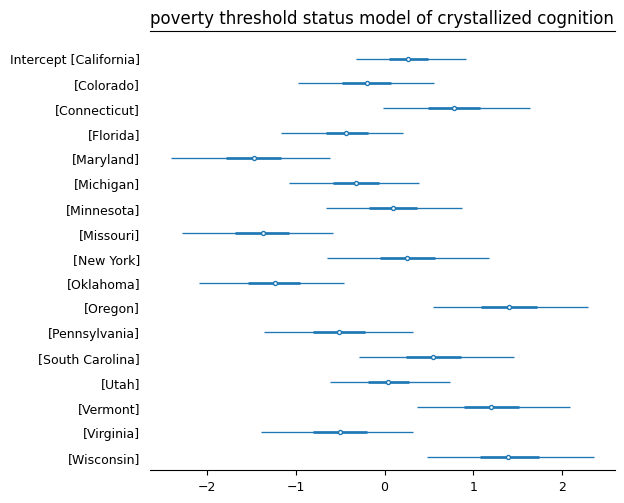

In [10]:
coords = {"abcd_state": [0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16]}
var_names = ["a_state"]
# Define the var_name_map and coord_map for custom labels
var_name_map = {"a_state": "Intercept "}
coord_map = {"abcd_state": { 0:'California', 1:'Colorado', 2:'Connecticut', 3:'Florida', 4:'Maryland',
       5:'Michigan', 6:'Minnesota', 7:'Missouri', 8:'New York', 9:'Oklahoma', 10:'Oregon',
       11:'Pennsylvania', 12:'South Carolina', 13:'Utah', 14:'Vermont', 15:'Virginia',
       16:'Wisconsin'}}

# Create the MapLabeller object
labeller = azl.MapLabeller(var_name_map=var_name_map, coord_map=coord_map)

axes= az.plot_forest(varying_intercept_slope_idata, var_names=var_names,coords=coords,labeller=labeller,combined=True, textsize=9);
fig = axes.ravel()[0].figure
plt.title("poverty threshold status model of crystallized cognition")
#ax.set_xticklabels(['-4','-2','0','2','4'],size=28)
#fig.set_yticklabels(['','-3','-2','-1','0','1','2','3'],size=28)
fig.savefig('forest_plot_state_intercept_pov_thresh_crystallized_cognition_results_f3.svg',transparent=True,dpi=600,format='svg')

/var/folders/vm/f5ddqzq57cnd0dhfcyvb42440000gn/T/ipykernel_65056/2950576278.py:1: MatplotlibDeprecationWarning: The seaborn styles shipped by Matplotlib are deprecated since 3.6, as they no longer correspond to the styles shipped by seaborn. However, they will remain available as 'seaborn-v0_8-<style>'. Alternatively, directly use the seaborn API instead.
  plt.style.use('seaborn-whitegrid')


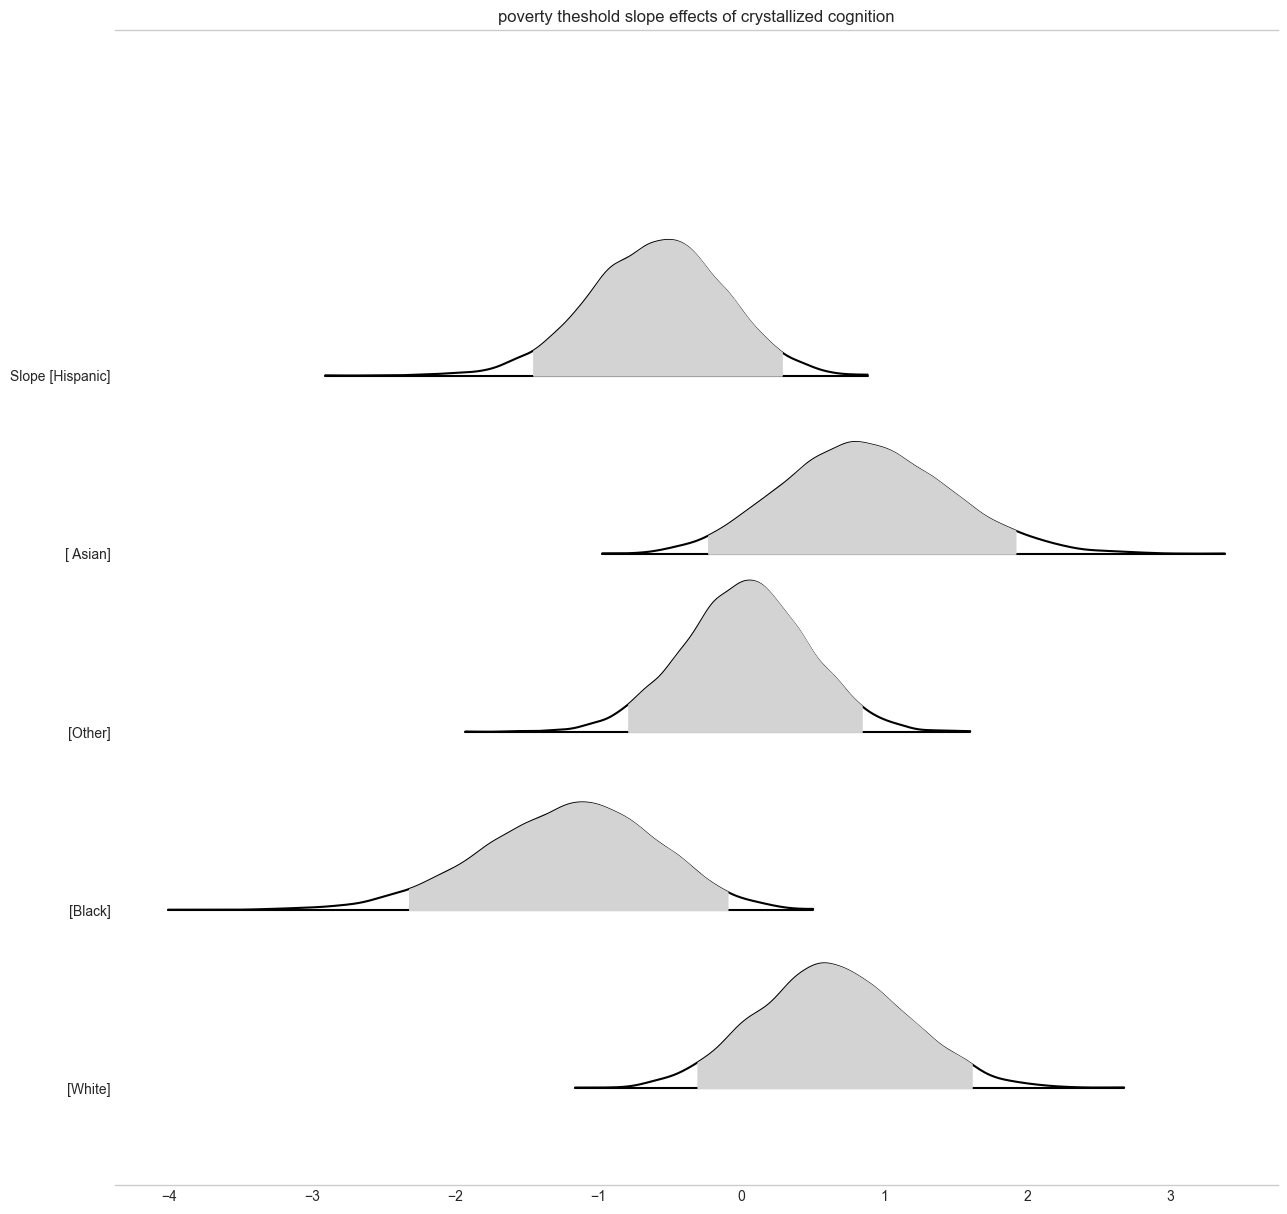

In [11]:
plt.style.use('seaborn-whitegrid')
coords = {"abcd_race": [0,1,2,3,4]}
var_names = ["b_race"]
# Define the var_name_map and coord_map for custom labels
var_name_map = {"b_race": "Slope "}
coord_map = {"abcd_race": { 0:"Hispanic", 1: " Asian", 2:"Other", 3:"Black", 4:"White"}}

# Create the MapLabeller object
labeller = azl.MapLabeller(var_name_map=var_name_map, coord_map=coord_map)

axes = az.plot_forest(varying_intercept_slope_idata,
                           kind='ridgeplot',var_names=var_names,coords=coords,labeller=labeller,
                           combined=True,
                           ridgeplot_truncate=False,
                           ridgeplot_overlap=0.7,
                           colors='lightgrey',
                           figsize=(15, 15))
fig = axes.ravel()[0].figure
plt.title("poverty theshold slope effects of crystallized cognition")
#ax.set_xticklabels(['-4','-2','0','2','4'],size=28)
#fig.set_yticklabels(['','-3','-2','-1','0','1','2','3'],size=28)
fig.savefig('forest_ridge_plot_race_slope_pov_thresh_crystallized_cognition_results_f3.svg',transparent=True,dpi=600,format='svg')

In [12]:
with varying_intercept_slope:
    ppc = pm.sample_posterior_predictive(varying_intercept_slope_idata, var_names=["likelihood","a_state","b_race"], random_seed=RANDOM_SEED)
    

In [13]:
# Bayesian R2 score 
az.r2_score(target_values, ppc['likelihood'])

r2        0.375091
r2_std    0.003589
dtype: float64

In [14]:
#create ppc dataframe 
PP_COL = ['pp_cog_{}'.format(i) for i in range(ppc['likelihood'].shape[0])]
ppc_df = pd.DataFrame(ppc['likelihood'].T, columns=PP_COL)
ppc_df.shape

(10843, 8000)

In [16]:
# get race, state and neighbourhood poverty threshold columns for ppc dataframe, reset index for merging dataframes
abcd_race_df = pd.DataFrame(data['race_ethnicity'],columns =['race_ethnicity']).reset_index(drop=True)
abcd_state_df = pd.DataFrame(data['site_id_l'],columns =['site_id_l']).reset_index(drop=True)
abcd_pov_df = pd.DataFrame(data['reshist_addr1_adi_b138_bin'],columns =['reshist_addr1_adi_b138_bin']).reset_index(drop=True)


In [17]:
ppc_df = pd.merge(abcd_race_df,ppc_df,left_index=True, right_index=True)
ppc_df = pd.merge(abcd_state_df,ppc_df,left_index=True, right_index=True)
ppc_df = pd.merge(abcd_pov_df,ppc_df,left_index=True, right_index=True)


In [18]:
ppc_pov_race_mean = (ppc_df.groupby(['reshist_addr1_adi_b138_bin','race_ethnicity']).apply(lambda df: df[PP_COL].mean(axis=0)))
ppc_pov_race_mean

pp_cog_0  pp_cog_1  pp_cog_2  \
reshist_addr1_adi_b138_bin race_ethnicity                                 
0.0                        Asian           0.261391  0.344004  0.217132   
                           Black           0.323435  0.167789  0.250588   
                           Hispanic        0.223185  0.255319  0.246008   
                           Other           0.225997  0.199551  0.209156   
                           White           0.290916  0.267963  0.268588   
1.0                        Asian           0.210968  0.624013  0.578194   
                           Black          -0.775182 -0.847875 -0.861603   
                           Hispanic       -0.416366 -0.511041 -0.526482   
                           Other          -0.103401 -0.149432 -0.105929   
                           White           0.208241  0.158880  0.196178   

                                           pp_cog_3  pp_cog_4  pp_cog_5  \
reshist_addr1_adi_b138_bin race_ethnicity                                 
0.0                        Asian           0.201638  0.206265  0.249994   
                           Black           0.285109  0.236286  0.227684   
                           Hispanic        0.263750  0.250393  0.223238   
                           Other           0.313886  0.235485  0.154153   
                           White           0.298336  0.279432  0.259022   
1.0                        Asian           0.592952  0.243409  0.082898   
                           Black          -0.809282 -0.801839 -0.851890   
                           Hispanic       -0.418491 -0.448671 -0.445514   
                           Other          -0.152640 -0.141295 -0.156128   
                           White           0.189499  0.210358  0.171366   

                                           pp_cog_6  pp_cog_7  pp_cog_8  \
reshist_addr1_adi_b138_bin race_ethnicity                                 
0.0                        Asian           0.256489  0.287331  0.282001   
                           Black           0.302596  0.307202  0.203431   
                           Hispanic        0.285691  0.210809  0.353667   
                           Other           0.208854  0.206228  0.279036   
                           White           0.268923  0.272524  0.288834   
1.0                        Asian           0.415778  0.287477  0.580742   
                           Black          -0.884680 -0.890488 -0.847012   
                           Hispanic       -0.488997 -0.487648 -0.486415   
                           Other          -0.148547 -0.187288 -0.082135   
                           White           0.216344  0.206828  0.193503   

                                           pp_cog_9  ...  pp_cog_7990  \
reshist_addr1_adi_b138_bin race_ethnicity            ...                
0.0                        Asian           0.319439  ...     0.238070   
                           Black           0.233402  ...     0.149316   
                           Hispanic        0.282412  ...     0.257213   
                           Other           0.196312  ...     0.248941   
                           White           0.254355  ...     0.297525   
1.0                        Asian           0.333552  ...     0.190912   
                           Black          -0.786512  ...    -0.805603   
                           Hispanic       -0.454065  ...    -0.497798   
                           Other          -0.221777  ...    -0.143142   
                           White           0.198586  ...     0.213524   

                                           pp_cog_7991  pp_cog_7992  \
reshist_addr1_adi_b138_bin race_ethnicity                             
0.0                        Asian              0.239582     0.341998   
                           Black              0.171615     0.183195   
                           Hispanic           0.316902     0.305551   
                           Other              0.220076     0.218389   
                           White     

In [19]:
ppc_pov_race_mean_summ=ppc_pov_race_mean.mean(axis=1)
ppc_pov_race_mean_summ

reshist_addr1_adi_b138_bin  race_ethnicity
0.0                         Asian             0.288716
                            Black             0.217264
                            Hispanic          0.266119
                            Other             0.252198
                            White             0.274575
1.0                         Asian             0.354435
                            Black            -0.841414
                            Hispanic         -0.458643
                            Other            -0.154807
                            White             0.190850
dtype: float64

In [20]:
ppc_race_mean = (ppc_df.groupby(['race_ethnicity']).apply(lambda df: df[PP_COL].mean(axis=0)))
ppc_race_mean

,pp_cog_0,pp_cog_1,pp_cog_2,pp_cog_3,pp_cog_4,pp_cog_5,pp_cog_6,pp_cog_7,pp_cog_8,pp_cog_9,...,pp_cog_7990,pp_cog_7991,pp_cog_7992,pp_cog_7993,pp_cog_7994,pp_cog_7995,pp_cog_7996,pp_cog_7997,pp_cog_7998,pp_cog_7999
race_ethnicity,,,,,,,,,,,,,,,,,,,,,
Asian,0.245222,0.433796,0.332915,0.327123,0.218176,0.196410,0.307569,0.287378,0.377800,0.323964,...,0.222948,0.256854,0.339684,0.223164,0.348530,0.468485,0.334180,0.381088,0.373932,0.253835
Black,-0.588842,-0.675605,-0.672961,-0.623659,-0.625759,-0.668780,-0.683302,-0.687344,-0.668842,-0.613521,...,-0.643636,-0.656591,-0.715011,-0.619827,-0.673204,-0.644865,-0.647484,-0.706978,-0.584543,-0.733413
Hispanic,-0.228573,-0.286013,-0.299654,-0.218163,-0.243403,-0.249146,-0.261524,-0.282558,-0.239740,-0.237812,...,-0.276102,-0.224644,-0.205051,-0.261521,-0.198474,-0.226809,-0.253396,-0.218401,-0.260705,-0.212377
Other,0.058823,0.022437,0.049246,0.077117,0.044263,-0.003320,0.027467,0.006513,0.095736,-0.015875,...,0.049953,0.015937,0.059496,0.043846,0.026876,0.016835,0.067163,0.064603,0.062176,0.021146
White,0.263081,0.231236,0.244208,0.261692,0.256176,0.229509,0.251220,0.250405,0.256737,0.235578,...,0.269243,0.224274,0.246496,0.266860,0.219287,0.228401,0.248013,0.246010,0.237686,0.257163


In [21]:
ppc_race_mean_summ = ppc_race_mean.mean(axis=1)

In [22]:
ppc_pov_state_mean = (ppc_df.groupby(['reshist_addr1_adi_b138_bin','site_id_l']).apply(lambda df: df[PP_COL].mean(axis=0)))
ppc_pov_state_mean_summ = ppc_pov_state_mean.mean(axis=1)


In [23]:
ppc_state_mean = (ppc_df.groupby(['site_id_l']).apply(lambda df: df[PP_COL].mean(axis=0)))
ppc_state_mean_summ = ppc_state_mean.mean(axis=1) #for the geomaps


In [24]:
ppc_pov_state_mean_summ_list=ppc_pov_state_mean_summ.to_numpy()
low_pov_state = ppc_pov_state_mean_summ_list[:17]
high_pov_state = ppc_pov_state_mean_summ_list[-17:]

In [25]:
mean_predictions_state = [low_pov_state,high_pov_state] 
  
# Create the pandas DataFrame 
mean_pred_state = pd.DataFrame(mean_predictions_state, columns=state) 
  
# print dataframe. 
mean_pred_state

,california,colorado,connecticut,florida,maryland,michigan,minnesota,missouri,newyork,oklahoma,oregon,pennsylvania,southcarolina,utah,vermont,virginia,wisconsin
0,0.297857,0.244671,0.354866,0.219126,0.101789,0.230226,0.277980,0.112706,0.294940,0.129326,0.422670,0.208638,0.328950,0.271889,0.401564,0.211601,0.422444
1,-0.298292,-0.158187,-0.292221,-0.373341,-0.718953,-0.255462,-0.011078,-0.492097,-0.285723,-0.378545,0.143309,-0.517194,-0.263473,0.033860,0.245469,-0.335487,0.006039


In [26]:
ppc_pov_race_mean_summ_list=ppc_pov_race_mean_summ.to_numpy()
low_pov_race = ppc_pov_race_mean_summ_list[:5]
high_pov_race = ppc_pov_race_mean_summ_list[-5:]

In [27]:
# initialize list of lists 
mean_predictions_race = [low_pov_race,high_pov_race] 
  
# Create the pandas DataFrame 
mean_pred_race = pd.DataFrame(mean_predictions_race, columns=["Asian","Black","Hispanic","Other","White"]) 
  
# print dataframe. 
mean_pred_race

,Asian,Black,Hispanic,Other,White
0,0.288716,0.217264,0.266119,0.252198,0.274575
1,0.354435,-0.841414,-0.458643,-0.154807,0.190850


In [28]:
#auxiliary data
census_data = pd.read_csv('/Users/nicoleosa/Documents/ABCD_data/census_poststrat_dataset.csv', usecols=['state','PovertyLT100_FPL_score','County_population','race_ethnicity'], index_col=False)
print(census_data.shape)

(1042, 4)


In [29]:
val = census_data['PovertyLT100_FPL_score'].median()
census_data.loc[census_data['PovertyLT100_FPL_score'] < val, 'PovertyLT100_FPL_score_bin'] = 0
census_data.loc[census_data['PovertyLT100_FPL_score'] >= val, 'PovertyLT100_FPL_score_bin'] = 1

In [30]:
census = (census_data.groupby(['state','race_ethnicity','PovertyLT100_FPL_score_bin']).County_population.agg(['sum']).reset_index())
census = census.rename(columns={'sum': 'freq'})
census

,state,race_ethnicity,PovertyLT100_FPL_score_bin,freq
0,california,Asian,0.0,767423
1,california,Asian,1.0,1067892
2,california,Black,0.0,3168044
3,california,Black,1.0,786431
4,california,Hispanic,0.0,6779394
...,...,...,...,...
136,wisconsin,Black,1.0,39628
137,wisconsin,Hispanic,0.0,88054
138,wisconsin,Other,0.0,183517
139,wisconsin,White,0.0,4001207


In [31]:
census['race_enc']=census['race_ethnicity']
census['race_enc'].replace(race,[0,1,2,3,4], inplace=True)
census['state_enc']=census['state']
census['state_enc'].replace(state,[0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16], inplace=True)
census.head()

,state,race_ethnicity,PovertyLT100_FPL_score_bin,freq,race_enc,state_enc
0,california,Asian,0.0,767423,1,0
1,california,Asian,1.0,1067892,1,0
2,california,Black,0.0,3168044,3,0
3,california,Black,1.0,786431,3,0
4,california,Hispanic,0.0,6779394,0,0


In [32]:
#fix theano shared tensor type error
census=census.astype({'PovertyLT100_FPL_score_bin':'uint8'})

In [33]:
#initialize poststrat vars
ps_abcd_race = census.race_enc.values
ps_abcd_state = census.state_enc.values
ps_pov = census.PovertyLT100_FPL_score_bin.values

#swap the model input variables 
abcd_race_.set_value(ps_abcd_race)
abcd_state_.set_value(ps_abcd_state)
pov_.set_value(ps_pov)

In [34]:
#re-run posterior predictive check with auxiliary census SDI data
with varying_intercept_slope:
    ppc2 = pm.sample_posterior_predictive(varying_intercept_slope_idata,var_names=['likelihood','a_state','b_race'],random_seed=RANDOM_SEED)
    

In [35]:
#create ppc dataframe 
PP_COL2 = ['pp_cog_{}'.format(i) for i in range(ppc2['likelihood'].shape[0])]
ppc_df2 = pd.DataFrame(ppc2['likelihood'].T, columns=PP_COL2)
ppc_df2.shape


(141, 8000)

In [36]:
censust=census
censust

,state,race_ethnicity,PovertyLT100_FPL_score_bin,freq,race_enc,state_enc
0,california,Asian,0,767423,1,0
1,california,Asian,1,1067892,1,0
2,california,Black,0,3168044,3,0
3,california,Black,1,786431,3,0
4,california,Hispanic,0,6779394,0,0
...,...,...,...,...,...,...
136,wisconsin,Black,1,39628,3,16
137,wisconsin,Hispanic,0,88054,0,16
138,wisconsin,Other,0,183517,2,16
139,wisconsin,White,0,4001207,4,16


In [37]:
# get race, state, and neighbourhood poverty threshold columns for ppc dataframe, reset index for merging dataframes
abcd_race_df2 = pd.DataFrame(censust['race_ethnicity'],columns =['race_ethnicity']).reset_index(drop=True)
abcd_state_df2 = pd.DataFrame(censust['state'],columns =['state']).reset_index(drop=True)
abcd_pov_df2 = pd.DataFrame(censust['PovertyLT100_FPL_score_bin'],columns =['PovertyLT100_FPL_score_bin']).reset_index(drop=True)


In [38]:
ppc_df2 = pd.merge(censust['freq'],ppc_df2,left_index=True, right_index=True)
ppc_df2 = pd.merge(abcd_pov_df2,ppc_df2,left_index=True, right_index=True)
ppc_df2 = pd.merge(abcd_race_df2,ppc_df2,left_index=True, right_index=True)
ppc_df2 = pd.merge(abcd_state_df2,ppc_df2,left_index=True, right_index=True)
ppc_df2

,state,race_ethnicity,PovertyLT100_FPL_score_bin,freq,pp_cog_0,pp_cog_1,pp_cog_2,pp_cog_3,pp_cog_4,pp_cog_5,...,pp_cog_7990,pp_cog_7991,pp_cog_7992,pp_cog_7993,pp_cog_7994,pp_cog_7995,pp_cog_7996,pp_cog_7997,pp_cog_7998,pp_cog_7999
0,california,Asian,0,767423,-0.582505,1.472814,-0.513373,0.648583,-0.876285,-0.114299,...,1.055768,0.353249,0.615247,-0.333700,0.585854,-1.041185,-0.742186,0.973687,1.580847,0.097038
1,california,Asian,1,1067892,1.374931,0.612034,1.574732,0.074795,0.676675,0.491776,...,-0.829332,-1.675788,-1.156164,0.437544,-0.604589,0.337543,1.269902,1.501045,0.260180,0.922382
2,california,Black,0,3168044,-1.468740,-1.835688,-0.604222,0.859402,-0.507675,1.120357,...,1.430364,0.859940,0.225903,-0.691348,0.477865,-0.788504,0.950234,-0.223674,0.534417,0.866719
3,california,Black,1,786431,-0.466842,-1.153511,-1.241135,0.016870,-0.187992,0.090387,...,0.659493,0.342042,-0.335247,-0.971851,-1.967832,0.586339,-0.125676,-1.906810,-2.643529,-0.085896
4,california,Hispanic,0,6779394,1.193371,1.117506,-0.818168,0.136972,0.893181,0.437707,...,0.576008,0.048677,0.079460,1.178192,-0.815057,0.443499,1.946755,0.103128,0.395760,0.805177
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
136,wisconsin,Black,1,39628,-2.217703,0.354485,0.595364,-0.244407,1.192352,1.227692,...,-1.582034,0.566430,0.166684,-0.931046,-2.396920,-0.685288,-0.028837,-1.300839,-2.873432,-0.126329
137,wisconsin,Hispanic,0,88054,-0.731578,0.736351,0.738857,0.438250,0.245341,-0.204142,...,0.965262,0.092403,-0.270129,-0.129642,2.429735,0.903699,-0.085149,0.217671,0.291560,0.140663
138,wisconsin,Other,0,183517,0.768945,-0.021472,0.260368,-0.134407,0.764009,0.895077,...,0.567622,0.882577,0.600508,-0.265841,-0.489525,0.378949,0.031281,1.915829,-0.330813,-1.003951
139,wisconsin,White,0,4001207,-1.059340,1.272609,0.250864,0.707728,1.103420,0.935781,...,0.425137,-0.529925,-0.041328,0.492799,0.960784,1.391617,0.992211,0.327760,1.384565,1.365584


In [39]:
#data-weighted for each category
ppc_poststrat_df = ppc_df2.groupby(['state','race_ethnicity','PovertyLT100_FPL_score_bin']).apply(lambda df: (df[PP_COL2]*df.freq.sum(axis=0)))
ppc_poststrat_df

pp_cog_0  \
state      race_ethnicity PovertyLT100_FPL_score_bin                     
california Asian          0                          0   -4.470281e+05   
                          1                          1    1.468277e+06   
           Black          0                          2   -4.653034e+06   
                          1                          3   -3.671388e+05   
           Hispanic       0                          4    8.090334e+06   
...                                                                ...   
wisconsin  Black          1                          136 -8.788312e+04   
           Hispanic       0                          137 -6.441840e+04   
           Other          0                          138  1.411144e+05   
           White          0                          139 -4.238640e+06   
                          1                          140  4.413038e+05   

                                                              pp_cog_1  \
state      race_ethnicity PovertyLT100_FPL_score_bin                     
california Asian          0                          0    1.130272e+06   
                          1                          1    6.535863e+05   
           Black          0                          2   -5.815541e+06   
                          1                          3   -9.071568e+05   
           Hispanic       0                          4    7.576016e+06   
...                                                                ...   
wisconsin  Black          1                          136  1.404755e+04   
           Hispanic       0                          137  6.483865e+04   
           Other          0                          138 -3.940483e+03   
           White          0                          139  5.091973e+06   
                          1                          140  1.363056e+05   

                                                              pp_cog_2  \
state      race_ethnicity PovertyLT100_FPL_score_bin                     
california Asian          0                          0   -3.939742e+05   
                          1                          1    1.681644e+06   
           Black          0                          2   -1.914202e+06   
                          1                          3   -9.760670e+05   
           Hispanic       0                          4   -5.546684e+06   
...                                                                ...   
wisconsin  Black          1                          136  2.359307e+04   
           Hispanic       0                          137  6.505930e+04   
           Other          0                          138  4.778202e+04   
           White          0                          139  1.003759e+06   
                          1                          140  2.091296e+05   

                                                              pp_cog_3  \
state      race_ethnicity PovertyLT100_FPL_score_bin                     
california Asian          0                          0    4.977378e+05   
                          1                          1    7.987301e+04   
           Black          0                          2    2.722624e+06   
                          1                          3    1.326698e+04   
           Hispanic       0                          4    9.285867e+05   
...                                                                ...   
wisconsin  Black          1                          136 -9.685364e+03   
           Hispanic       0                          137  3.858964e+04   
           Other          0                          138 -2.466596e+04   
           White          0                          139  2.831765e+06   
                          1                          140 -9.456314e+04   

                                                              pp_cog_4  \
state      race_ethnicity PovertyLT100_FPL_score_bin                     
california Asian          0                          0   -6.72

In [40]:
#re-format groupby to remove multi-index
ppc_poststrat_df = ppc_poststrat_df.to_numpy()
ppc_poststrat_df = pd.DataFrame(ppc_poststrat_df, columns=PP_COL2)
ppc_poststrat_df

,pp_cog_0,pp_cog_1,pp_cog_2,pp_cog_3,pp_cog_4,pp_cog_5,pp_cog_6,pp_cog_7,pp_cog_8,pp_cog_9,...,pp_cog_7990,pp_cog_7991,pp_cog_7992,pp_cog_7993,pp_cog_7994,pp_cog_7995,pp_cog_7996,pp_cog_7997,pp_cog_7998,pp_cog_7999
0,-4.470281e+05,1.130272e+06,-3.939742e+05,4.977378e+05,-6.724811e+05,-8.771542e+04,1.802150e+05,9.022579e+05,9.731521e+05,3.730754e+04,...,8.102207e+05,2.710913e+05,4.721551e+05,-2.560894e+05,4.495978e+05,-7.990295e+05,-5.695704e+05,7.472297e+05,1.213179e+06,7.446920e+04
1,1.468277e+06,6.535863e+05,1.681644e+06,7.987301e+04,7.226157e+05,5.251641e+05,1.363738e+06,6.441448e+05,2.031435e+06,1.298992e+06,...,-8.856370e+05,-1.789561e+06,-1.234658e+06,4.672492e+05,-6.456357e+05,3.604595e+05,1.356118e+06,1.602954e+06,2.778446e+05,9.850043e+05
2,-4.653034e+06,-5.815541e+06,-1.914202e+06,2.722624e+06,-1.608337e+06,3.549340e+06,3.802008e+06,3.474534e+06,-1.634259e+06,9.328623e+05,...,4.531457e+06,2.724329e+06,7.156705e+05,-2.190222e+06,1.513898e+06,-2.498015e+06,3.010382e+06,-7.086097e+05,1.693057e+06,2.745805e+06
3,-3.671388e+05,-9.071568e+05,-9.760670e+05,1.326698e+04,-1.478424e+05,7.108336e+04,-1.550754e+06,-9.935130e+05,-1.001231e+06,-1.181198e+06,...,5.186458e+05,2.689921e+05,-2.636489e+05,-7.642939e+05,-1.547564e+06,4.611149e+05,-9.883580e+04,-1.499575e+06,-2.078953e+06,-6.755146e+04
4,8.090334e+06,7.576016e+06,-5.546684e+06,9.285867e+05,6.055227e+06,2.967389e+06,6.460774e+06,-2.670115e+06,8.981821e+06,1.263382e+05,...,3.904983e+06,3.299983e+05,5.386878e+05,7.987427e+06,-5.525596e+06,3.006653e+06,1.319782e+07,6.991440e+05,2.683016e+06,5.458612e+06
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
136,-8.788312e+04,1.404755e+04,2.359307e+04,-9.685364e+03,4.725052e+04,4.865098e+04,-5.002246e+04,-1.949070e+04,-1.084128e+05,-5.134005e+04,...,-6.269285e+04,2.244649e+04,6.605340e+03,-3.689547e+04,-9.498513e+04,-2.715660e+04,-1.142753e+03,-5.154965e+04,-1.138683e+05,-5.006162e+03
137,-6.441840e+04,6.483865e+04,6.505930e+04,3.858964e+04,2.160324e+04,-1.797548e+04,6.561800e+04,1.162991e+05,2.873751e+04,1.626333e+05,...,8.499517e+04,8.136428e+03,-2.378594e+04,-1.141546e+04,2.139479e+05,7.957429e+04,-7.497699e+03,1.916681e+04,2.567300e+04,1.238592e+04
138,1.411144e+05,-3.940483e+03,4.778202e+04,-2.466596e+04,1.402086e+05,1.642618e+05,2.566993e+05,7.609276e+04,-1.502741e+05,3.433550e+05,...,1.041683e+05,1.619678e+05,1.102035e+05,-4.878627e+04,-8.983609e+04,6.954351e+04,5.740586e+03,3.515871e+05,-6.070973e+04,-1.842422e+05
139,-4.238640e+06,5.091973e+06,1.003759e+06,2.831765e+06,4.415013e+06,3.744254e+06,4.916251e+06,4.322004e+05,1.625102e+06,3.027509e+06,...,1.701062e+06,-2.120340e+06,-1.653620e+05,1.971791e+06,3.844296e+06,5.568149e+06,3.970043e+06,1.311434e+06,5.539932e+06,5.463983e+06


In [41]:
ppc_df2_sub = ppc_df2.iloc[:, : 4] #get the input var, race, state and freq columns, to perform another group by for the final posstratification step
ppc_df2_sub

,state,race_ethnicity,PovertyLT100_FPL_score_bin,freq
0,california,Asian,0,767423
1,california,Asian,1,1067892
2,california,Black,0,3168044
3,california,Black,1,786431
4,california,Hispanic,0,6779394
...,...,...,...,...
136,wisconsin,Black,1,39628
137,wisconsin,Hispanic,0,88054
138,wisconsin,Other,0,183517
139,wisconsin,White,0,4001207


In [42]:
ppc_poststrat_df = pd.merge(ppc_df2_sub,ppc_poststrat_df,left_index=True, right_index=True) #merge the extracted colums with the dataframe from the first step of poststratification
ppc_poststrat_df

,state,race_ethnicity,PovertyLT100_FPL_score_bin,freq,pp_cog_0,pp_cog_1,pp_cog_2,pp_cog_3,pp_cog_4,pp_cog_5,...,pp_cog_7990,pp_cog_7991,pp_cog_7992,pp_cog_7993,pp_cog_7994,pp_cog_7995,pp_cog_7996,pp_cog_7997,pp_cog_7998,pp_cog_7999
0,california,Asian,0,767423,-4.470281e+05,1.130272e+06,-3.939742e+05,4.977378e+05,-6.724811e+05,-8.771542e+04,...,8.102207e+05,2.710913e+05,4.721551e+05,-2.560894e+05,4.495978e+05,-7.990295e+05,-5.695704e+05,7.472297e+05,1.213179e+06,7.446920e+04
1,california,Asian,1,1067892,1.468277e+06,6.535863e+05,1.681644e+06,7.987301e+04,7.226157e+05,5.251641e+05,...,-8.856370e+05,-1.789561e+06,-1.234658e+06,4.672492e+05,-6.456357e+05,3.604595e+05,1.356118e+06,1.602954e+06,2.778446e+05,9.850043e+05
2,california,Black,0,3168044,-4.653034e+06,-5.815541e+06,-1.914202e+06,2.722624e+06,-1.608337e+06,3.549340e+06,...,4.531457e+06,2.724329e+06,7.156705e+05,-2.190222e+06,1.513898e+06,-2.498015e+06,3.010382e+06,-7.086097e+05,1.693057e+06,2.745805e+06
3,california,Black,1,786431,-3.671388e+05,-9.071568e+05,-9.760670e+05,1.326698e+04,-1.478424e+05,7.108336e+04,...,5.186458e+05,2.689921e+05,-2.636489e+05,-7.642939e+05,-1.547564e+06,4.611149e+05,-9.883580e+04,-1.499575e+06,-2.078953e+06,-6.755146e+04
4,california,Hispanic,0,6779394,8.090334e+06,7.576016e+06,-5.546684e+06,9.285867e+05,6.055227e+06,2.967389e+06,...,3.904983e+06,3.299983e+05,5.386878e+05,7.987427e+06,-5.525596e+06,3.006653e+06,1.319782e+07,6.991440e+05,2.683016e+06,5.458612e+06
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
136,wisconsin,Black,1,39628,-8.788312e+04,1.404755e+04,2.359307e+04,-9.685364e+03,4.725052e+04,4.865098e+04,...,-6.269285e+04,2.244649e+04,6.605340e+03,-3.689547e+04,-9.498513e+04,-2.715660e+04,-1.142753e+03,-5.154965e+04,-1.138683e+05,-5.006162e+03
137,wisconsin,Hispanic,0,88054,-6.441840e+04,6.483865e+04,6.505930e+04,3.858964e+04,2.160324e+04,-1.797548e+04,...,8.499517e+04,8.136428e+03,-2.378594e+04,-1.141546e+04,2.139479e+05,7.957429e+04,-7.497699e+03,1.916681e+04,2.567300e+04,1.238592e+04
138,wisconsin,Other,0,183517,1.411144e+05,-3.940483e+03,4.778202e+04,-2.466596e+04,1.402086e+05,1.642618e+05,...,1.041683e+05,1.619678e+05,1.102035e+05,-4.878627e+04,-8.983609e+04,6.954351e+04,5.740586e+03,3.515871e+05,-6.070973e+04,-1.842422e+05
139,wisconsin,White,0,4001207,-4.238640e+06,5.091973e+06,1.003759e+06,2.831765e+06,4.415013e+06,3.744254e+06,...,1.701062e+06,-2.120340e+06,-1.653620e+05,1.971791e+06,3.844296e+06,5.568149e+06,3.970043e+06,1.311434e+06,5.539932e+06,5.463983e+06


In [43]:
#final step of poststratification - by race & poverty threshold 
#data-weighted average
ppc_pov_race_poststrat = ppc_poststrat_df.groupby(['PovertyLT100_FPL_score_bin','race_ethnicity']).apply(lambda df: (df[PP_COL2].sum(axis=0))/df.freq.sum(axis=0))
ppc_pov_race_poststrat


pp_cog_0  pp_cog_1  pp_cog_2  \
PovertyLT100_FPL_score_bin race_ethnicity                                 
0                          Asian           0.548297  0.423222  0.118103   
                           Black          -0.127455 -0.058728  0.284943   
                           Hispanic        0.928246  1.129845 -0.163497   
                           Other           1.012747  0.581267  0.397593   
                           White          -0.029806  0.978543 -0.559593   
1                          Asian           0.684164 -0.026001  1.207359   
                           Black          -0.473400 -0.600169 -1.166045   
                           Hispanic        0.429858 -0.967064 -0.203063   
                           Other          -0.982802  0.607565 -0.146194   
                           White           0.211204  0.225644  0.233817   

                                           pp_cog_3  pp_cog_4  pp_cog_5  \
PovertyLT100_FPL_score_bin race_ethnicity                                 
0                          Asian           0.145475 -0.359529  0.712329   
                           Black           0.447353  0.200443  0.618388   
                           Hispanic       -0.030600  0.218602  0.311821   
                           Other          -0.115214  0.009035 -0.617959   
                           White           0.547075 -0.070417  0.620265   
1                          Asian           0.284119  0.485347  0.221958   
                           Black          -0.612649 -0.752362 -1.177824   
                           Hispanic       -0.801417 -0.121133 -0.713097   
                           Other           0.268628  0.155792  0.016633   
                           White           0.607363  0.620555  0.084941   

                                           pp_cog_6  pp_cog_7  pp_cog_8  \
PovertyLT100_FPL_score_bin race_ethnicity                                 
0                          Asian           1.027305  0.002829 -0.199985   
                           Black           0.464508  0.250273  0.369347   
                           Hispanic        0.502924 -0.207543  0.603772   
                           Other           1.347515  0.685120 -0.131857   
                           White           0.323184  0.515150 -0.060933   
1                          Asian           0.914534  0.670203  0.640167   
                           Black          -0.988923 -0.686942 -1.062970   
                           Hispanic       -0.662486 -0.682539 -0.903173   
                           Other          -0.268369 -1.692305  0.204963   
                           White           0.355919  0.380310 -0.007729   

                                           pp_cog_9  ...  pp_cog_7990  \
PovertyLT100_FPL_score_bin race_ethnicity            ...                
0                          Asian           0.692746  ...     0.042229   
                           Black           0.448298  ...     0.373183   
                           Hispanic        0.175954  ...     0.377077   
                           Other           0.556367  ...    -0.305638   
                           White          -0.084887  ...     0.692176   
1                          Asian           0.581701  ...     0.384241   
                           Black          -0.744199  ...    -0.554702   
                           Hispanic       -0.045562  ...    -1.300982   
                           Other           0.117892  ...    -0.400327   
                           White           0.184939  ...    -0.380620   

                                           pp_cog_7991  pp_cog_7992  \
PovertyLT100_FPL_score_bin race_ethnicity                             
0                          Asian              0.152433     0.279014   
                           Black              0.011924     0.175544   
                           Hispanic           0.265813     0.216029   
                           Other              0.922689     0.200851   
                           White     

In [44]:
#summarize race & poverty threshold poststrat results
ppc_pov_race_poststrat_summ = ppc_pov_race_poststrat.mean(axis=1)
ppc_pov_race_poststrat_summ

PovertyLT100_FPL_score_bin  race_ethnicity
0                           Asian             0.243264
                            Black             0.226386
                            Hispanic          0.261916
                            Other             0.254711
                            White             0.282380
1                           Asian             0.343744
                            Black            -0.808260
                            Hispanic         -0.465134
                            Other            -0.142933
                            White             0.183654
dtype: float64

In [45]:
#final step postrat - by race
ppc_race_poststrat = ppc_poststrat_df.groupby(['race_ethnicity']).apply(lambda df: (df[PP_COL2].sum(axis=0))/df.freq.sum(axis=0))
ppc_race_poststrat_summ = ppc_race_poststrat.mean(axis=1)
ppc_race_poststrat_summ


race_ethnicity
Asian       0.268733
Black      -0.022231
Hispanic   -0.111794
Other       0.014081
White       0.232279
dtype: float64

In [46]:
#for the lollipops
#final step poststrat - by state & ppoverty threshold
ppc_pov_state_poststrat = ppc_poststrat_df.groupby(['PovertyLT100_FPL_score_bin','state']).apply(lambda df: (df[PP_COL2].sum(axis=0))/df.freq.sum(axis=0))
ppc_pov_state_poststrat_summ = ppc_pov_state_poststrat.mean(axis=1)
ppc_pov_state_poststrat_summ

PovertyLT100_FPL_score_bin  state        
0                           california       0.305841
                            colorado         0.237288
                            connecticut      0.357930
                            florida          0.219556
                            maryland         0.095701
                            michigan         0.226016
                            minnesota        0.279410
                            missouri         0.110117
                            newyork          0.293513
                            oklahoma         0.123123
                            oregon           0.421599
                            pennsylvania     0.210799
                            southcarolina    0.323618
                            utah             0.285278
                            vermont          0.408359
                            virginia         0.222154
                            wisconsin        0.427331
1                           california  

In [47]:
#for the geomaps
#final step poststrat - by state
ppc_state_poststrat = ppc_poststrat_df.groupby(['state']).apply(lambda df: (df[PP_COL2].sum(axis=0))/df.freq.sum(axis=0))
ppc_state_poststrat_summ = ppc_state_poststrat.mean(axis=1)
ppc_state_poststrat_summ

state
california       0.177733
colorado         0.179127
connecticut      0.357930
florida         -0.071712
maryland        -0.048730
michigan         0.150774
minnesota        0.248936
missouri        -0.037765
newyork          0.068432
oklahoma        -0.044625
oregon           0.300285
pennsylvania     0.166875
southcarolina    0.069830
utah             0.242507
vermont          0.397712
virginia         0.140364
wisconsin        0.425731
dtype: float64

In [48]:
ppc_pov_state_poststrat_summ_list=ppc_pov_state_poststrat_summ.tolist()

In [49]:
#fill in missing value for connecticut
ppc_pov_state_poststrat_summ_list.insert(19,ppc_pov_state_mean_summ.iloc[19])

In [51]:
low_pov_state_poststrat = ppc_pov_state_poststrat_summ_list[:17]
high_pov_state_poststrat = ppc_pov_state_poststrat_summ_list[-17:]

In [52]:
ppc_pov_race_poststrat_summ_list=ppc_pov_race_poststrat_summ.tolist()

In [53]:
low_pov_race_poststrat = ppc_pov_race_poststrat_summ_list[:5]
high_pov_race_poststrat = ppc_pov_race_poststrat_summ_list[-5:]

In [54]:
mean_predictions_state_ps = [low_pov_state_poststrat,high_pov_state_poststrat] 
  
# Create the pandas DataFrame 
mean_pred_state_ps = pd.DataFrame(mean_predictions_state_ps, columns=state) 
  
# print dataframe. 
mean_pred_state_ps

,california,colorado,connecticut,florida,maryland,michigan,minnesota,missouri,newyork,oklahoma,oregon,pennsylvania,southcarolina,utah,vermont,virginia,wisconsin
0,0.305841,0.237288,0.357930,0.219556,0.095701,0.226016,0.279410,0.110117,0.293513,0.123123,0.421599,0.210799,0.323618,0.285278,0.408359,0.222154,0.427331
1,0.080223,-0.279471,-0.292221,-0.342053,-0.899005,0.081835,0.117216,-0.155843,-0.126015,-0.089217,0.224487,0.060917,-0.051349,-0.172838,0.318948,-0.056711,0.419905


In [55]:
# initialize list of lists 
mean_predictions_race_ps = [low_pov_race_poststrat,high_pov_race_poststrat] 
  
# Create the pandas DataFrame 
mean_pred_race_ps = pd.DataFrame(mean_predictions_race_ps, columns=["Asian","Black","Hispanic","Other","White"]) 
  
# print dataframe. 
mean_pred_race_ps

,Asian,Black,Hispanic,Other,White
0,0.243264,0.226386,0.261916,0.254711,0.282380
1,0.343744,-0.808260,-0.465134,-0.142933,0.183654


In [56]:
quantiles = [0.5]

# Calculate quantiles for each row (state)
quantiles_per_state = np.quantile(ppc_state_mean, quantiles, axis=1)
quantiles_per_state_ps = np.quantile(ppc_state_poststrat, quantiles, axis=1)

# Convert to list of lists
quantiles_state = quantiles_per_state.flatten().tolist()
quantiles_state_ps = quantiles_per_state_ps.flatten().tolist()

quantiles_state,quantiles_state_ps

([-0.048365605943827245,
  0.13183214565576937,
  0.11649507565068279,
  -0.23397796596821285,
  -0.22134751505771694,
  0.0031873052393740055,
  0.20496139090150484,
  -0.20446724370771865,
  0.013079296662578455,
  -0.1711400753884122,
  0.25858706801069264,
  -0.392194375098905,
  0.029362119761712907,
  0.17979143789147647,
  0.3548446307653559,
  -0.0553668608459954,
  0.2959978191763336],
 [0.17927135514789858,
  0.17397247039766378,
  0.3507225276256528,
  -0.07541345250064493,
  -0.05214040307914358,
  0.14725691074277278,
  0.2508807438294458,
  -0.039694033759823014,
  0.06494639848928342,
  -0.04880244410892606,
  0.2905978418160705,
  0.17371886740369397,
  0.07489085463019768,
  0.2496959635971366,
  0.4011772981144781,
  0.1330928785106378,
  0.4276931431993686])

In [57]:
capitalized_states=['California',
 'Colorado',
 'Connecticut',
 'Florida',
 'Maryland',
 'Michigan',
 'Minnesota',
 'Missouri',
 'New York',
 'Oklahoma',
 'Oregon',
 'Pennsylvania',
 'South Carolina',
 'Utah',
 'Vermont',
 'Virginia',
 'Wisconsin']

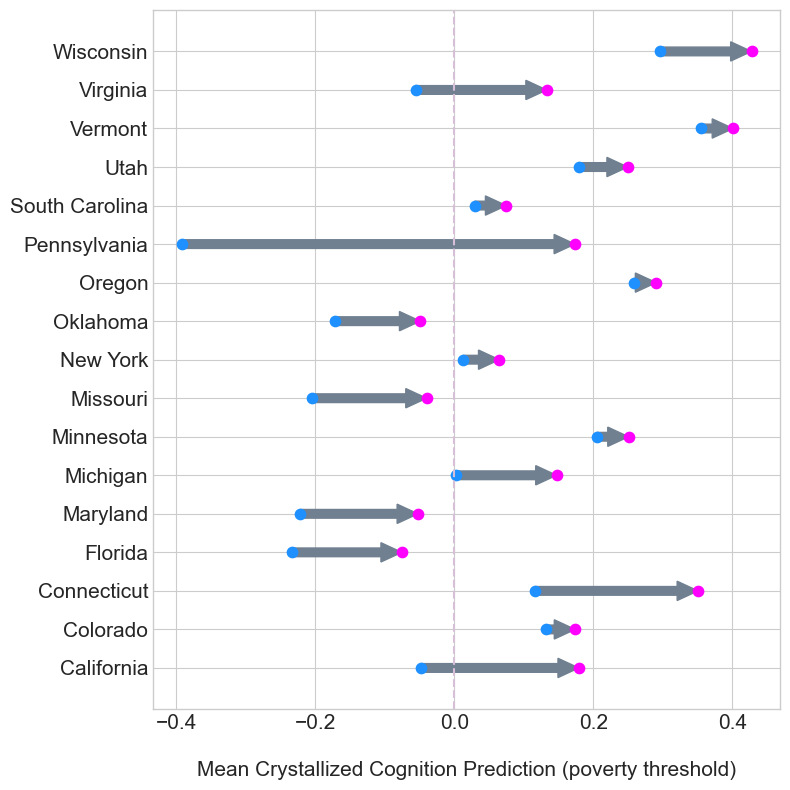

In [58]:
states = capitalized_states
quartiles_before_ps = quantiles_state   # mean prediction before poststratification
quartiles_after_ps = quantiles_state_ps  # mean prediction after poststratification

# Plotting
plt.figure(figsize=(8, 8))

# Plot arrows indicating change from before to after poststratification
for i in range(len(states)):
    plt.arrow(quartiles_before_ps[i], i, quartiles_after_ps[i] - quartiles_before_ps[i], 0, color='slategrey', width=0.225, head_width=0.5, head_length=0.03, length_includes_head=True)

# Plot second quartiles before poststratification
for i, state in enumerate(states):
    plt.scatter(quartiles_before_ps[i], i, marker='o', color='dodgerblue', label='Before PS' if i == 0 else "",s=55)  # Dot for second quartile

# Plot second quartiles after poststratification
for i, state in enumerate(states):
    plt.scatter(quartiles_after_ps[i], i, marker='o', color='fuchsia', label='After PS' if i == 0 else "",s=55)  # Dot for second quartile

# Add vertical dashed line at x = 0
plt.axvline(x=0, color='thistle', linestyle='--')

plt.yticks(range(len(states)), states,size=15)
plt.xticks(size=15)
plt.xlabel('Mean Crystallized Cognition Prediction (poverty threshold)',size=15,labelpad=20)
#plt.title('Mean Predictions of Crystallized Cognition based on Poverty Threshold Before and After Poststratification')
plt.grid(True)
#plt.legend()
#plt.legend(loc='upper right', bbox_to_anchor=(1.5, 1.0),frameon=True)
plt.tight_layout()
plt.savefig('arrow_plot_pov_thresh_crystallized_ps_state_cognition_results_f4.svg',transparent=True,dpi=600, bbox_inches='tight',format='svg')
plt.show()

In [59]:
quantiles_per_race = np.quantile(ppc_race_mean, quantiles, axis=1)
quantiles_per_race_ps = np.quantile(ppc_race_poststrat, quantiles, axis=1)

# Convert to list of lists
quantiles_race = quantiles_per_race.flatten().tolist()
quantiles_race_ps = quantiles_per_race_ps.flatten().tolist()

quantiles_race,quantiles_race_ps

([0.3088837945000726,
  -0.6621085773174997,
  -0.2459406628326814,
  0.04574816089856701,
  0.24643263768896018],
 [0.26771985252435554,
  -0.024416636152191713,
  -0.11260628832154712,
  0.015226464408595,
  0.2327582252523184])

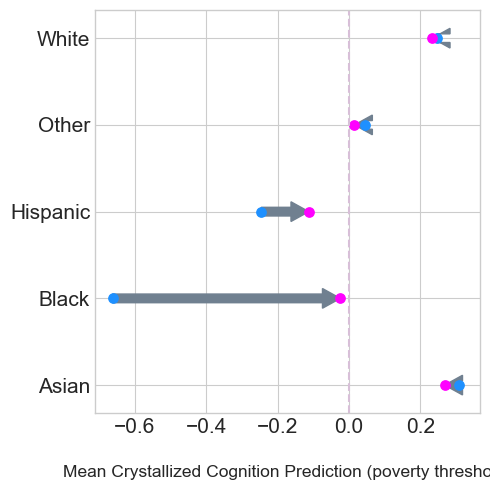

In [60]:
races = ['Asian','Black','Hispanic','Other','White']
quartiles_before_ps_r = quantiles_race   # mean prediction before poststratification
quartiles_after_ps_r = quantiles_race_ps  # mean prediction after poststratification

# Plotting
plt.figure(figsize=(5, 5))

# Plot arrows indicating change from before to after poststratification
for i in range(len(races)):
    plt.arrow(quartiles_before_ps_r[i], i, quartiles_after_ps_r[i] - quartiles_before_ps_r[i], 0, color='slategrey', width=0.10, head_width=0.227, head_length=0.05, length_includes_head=True)

# Plot second quartiles before poststratification
for i, race in enumerate(races):
    plt.scatter(quartiles_before_ps_r[i], i, marker='o', color='dodgerblue', label='Before PS' if i == 0 else "",s=45)  # Dot for second quartile

# Plot second quartiles after poststratification
for i, race in enumerate(races):
    plt.scatter(quartiles_after_ps_r[i], i, marker='o', color='fuchsia', label='After PS' if i == 0 else "",s=45)  # Dot for second quartile

# Add vertical dashed line at x = 0
plt.axvline(x=0, color='thistle', linestyle='--')

plt.yticks(range(len(races)), races,size=15)
plt.xticks(size=15)
plt.xlabel('Mean Crystallized Cognition Prediction (poverty threshold)',size=12.5,labelpad=20)
#plt.title('Mean Predictions of Crystallized Cognition based on Poverty Threshold Before and After Poststratification')
plt.grid(True)
#plt.legend()
#plt.legend(loc='upper right', bbox_to_anchor=(1.5, 1.0),frameon=True)
plt.tight_layout()
plt.savefig('arrow_plot_pov_thresh_crystallized_ps_race_cognition_results_f4.svg',transparent=True,dpi=600, bbox_inches='tight',format='svg')
plt.show()

/var/folders/vm/f5ddqzq57cnd0dhfcyvb42440000gn/T/ipykernel_65056/2901204698.py:42: UserWarning: color is redundantly defined by the 'color' keyword argument and the fmt string "k-" (-> color='k'). The keyword argument will take precedence.
  plt.plot(state_values, [state_name, state_name], 'k-',color='thistle', linewidth=8,zorder=1,label='before PS')  # Connect the points for the state
/var/folders/vm/f5ddqzq57cnd0dhfcyvb42440000gn/T/ipykernel_65056/2901204698.py:43: UserWarning: color is redundantly defined by the 'color' keyword argument and the fmt string "k-" (-> color='k'). The keyword argument will take precedence.
  plt.plot(state_values2, [state_name2, state_name2], 'k-',color='violet', linewidth=8,zorder=1,label='after PS')  # Connect the points for the state


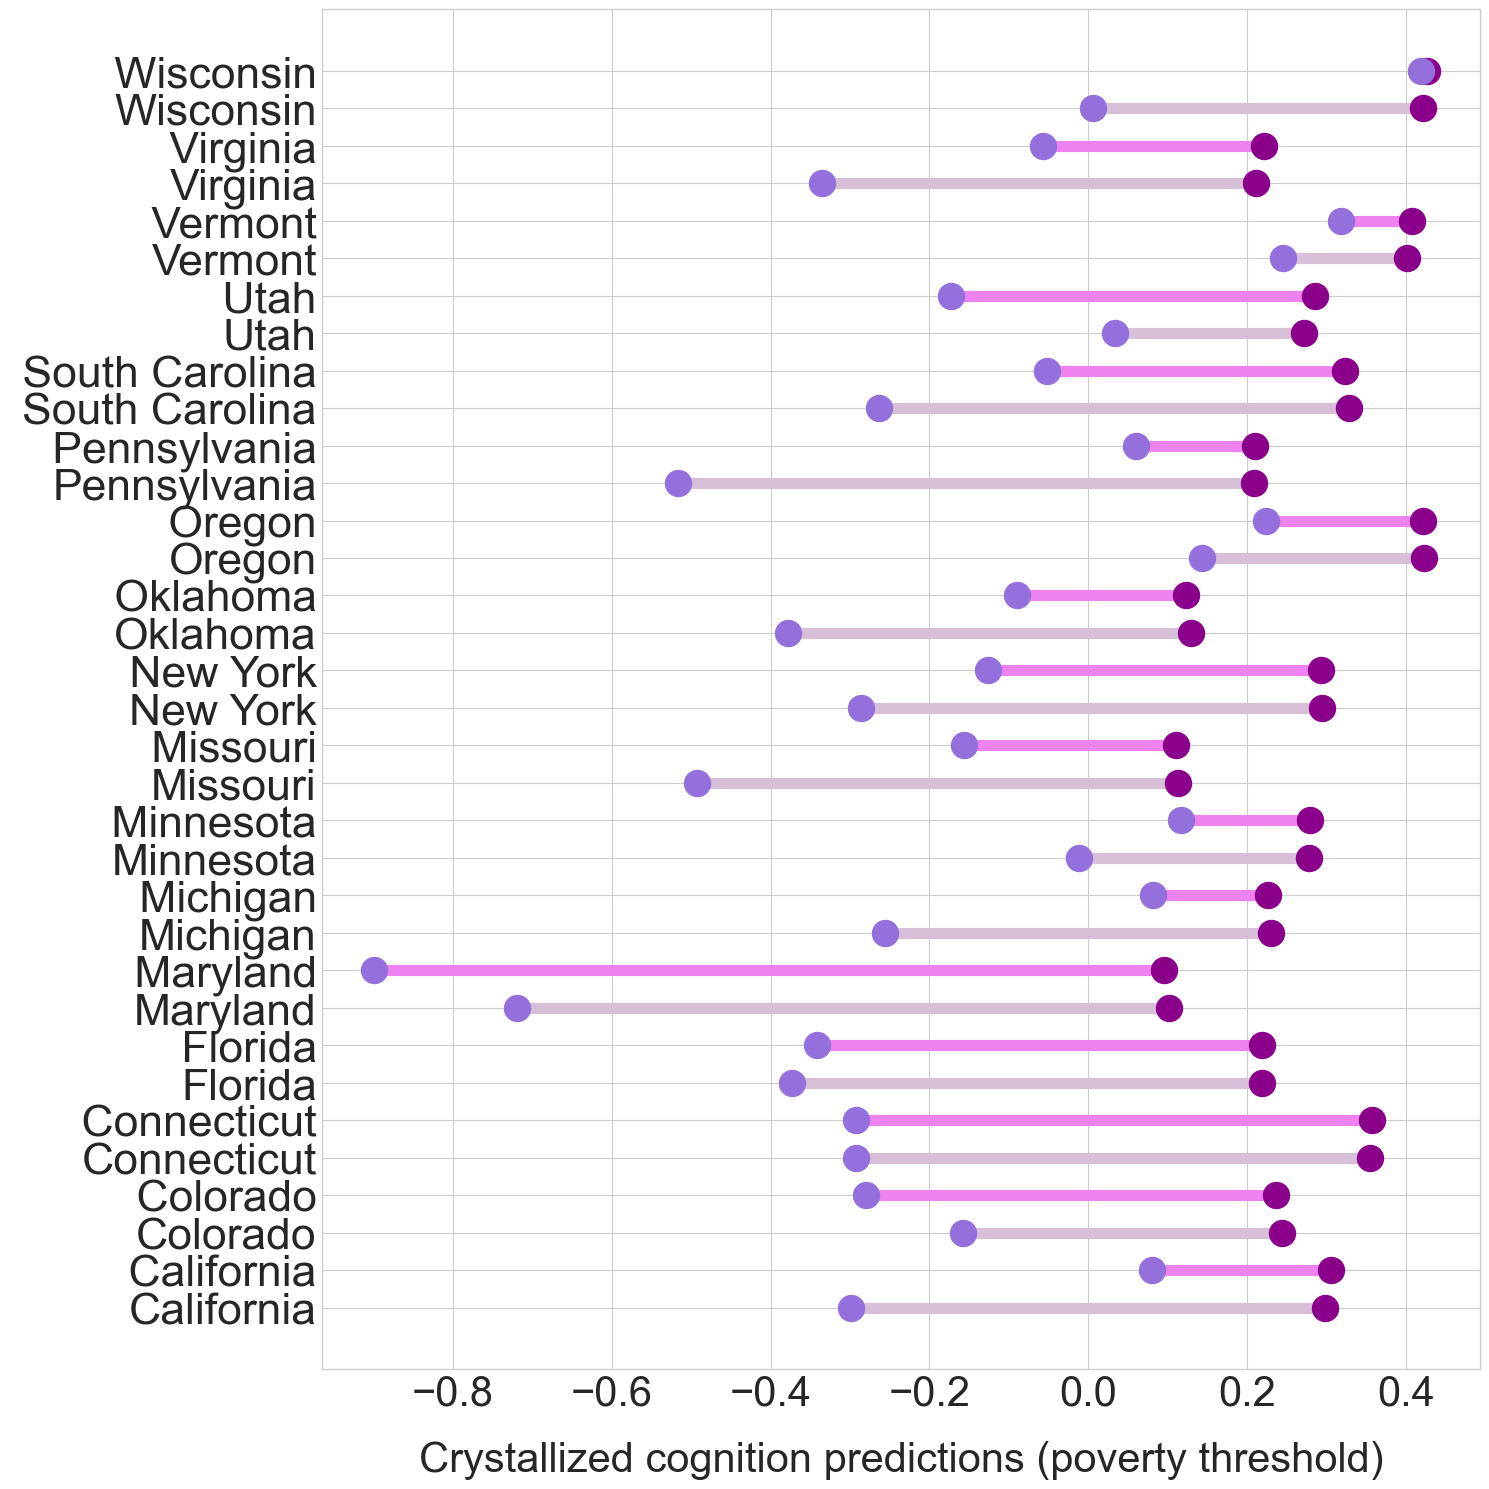

In [61]:
datas=mean_predictions_state
datas2=mean_predictions_state_ps
state_names = ['California',
 'Colorado',
 'Connecticut',
 'Florida',
 'Maryland',
 'Michigan',
 'Minnesota',
 'Missouri',
 'New York',
 'Oklahoma',
 'Oregon',
 'Pennsylvania',
 'South Carolina',
 'Utah',
 'Vermont',
 'Virginia',
 'Wisconsin']
state_names2 = [' California',
 ' Colorado',
 ' Connecticut',
 ' Florida',
 ' Maryland',
 ' Michigan',
 ' Minnesota',
 ' Missouri',
 ' New York',
 ' Oklahoma',
 ' Oregon',
 ' Pennsylvania',
 ' South Carolina',
 ' Utah',
 ' Vermont',
 ' Virginia',
 ' Wisconsin']
# Plotting
plt.figure(figsize=(15, 15))

# Transpose the data matrix to iterate over states
for state_name, state_values,state_name2, state_values2 in zip(state_names, np.array(datas).T,state_names2, np.array(datas2).T):
    plt.plot(state_values, [state_name, state_name], 'k-',color='thistle', linewidth=8,zorder=1,label='before PS')  # Connect the points for the state
    plt.plot(state_values2, [state_name2, state_name2], 'k-',color='violet', linewidth=8,zorder=1,label='after PS')  # Connect the points for the state
    
    plt.scatter(state_values[0], state_name, color='darkmagenta', label='low pov oc', s=350,zorder=2)  # Plot value 1 for the state
    plt.scatter(state_values[1], state_name, color='mediumpurple', label='high pov oc', s=350,zorder=2)  # Plot value 2 for the state
    
    plt.scatter(state_values2[0], state_name2, color='darkmagenta', s=350,zorder=2)  # Plot value 1 for the state
    plt.scatter(state_values2[1], state_name2, color='mediumpurple', s=350,zorder=2)  # Plot value 2 for the state
    
plt.xticks(size=30)
plt.yticks(size=32)
plt.xlabel('Crystallized cognition predictions (poverty threshold)',size= 30,labelpad=20)
#plt.ylabel('States',size=25)
#plt.title('Values for Each State')
#plt.legend(['before PS','after PS','low pov oc', 'high pov oc'],loc='upper right', bbox_to_anchor=(1.5, 1.0),frameon=True)
plt.grid(True)
plt.tight_layout()
plt.savefig('lolli_plot_pov_thresh_crystallized_ps_state_cognition_results_f5.svg',transparent=True,dpi=600, bbox_inches='tight',format='svg')
plt.show()


/var/folders/vm/f5ddqzq57cnd0dhfcyvb42440000gn/T/ipykernel_65056/2846322821.py:19: UserWarning: color is redundantly defined by the 'color' keyword argument and the fmt string "k-" (-> color='k'). The keyword argument will take precedence.
  plt.plot(race_values, [race_name, race_name], 'k-',color='thistle', linewidth=8,zorder=1,label='before PS')  # Connect the points for the state
/var/folders/vm/f5ddqzq57cnd0dhfcyvb42440000gn/T/ipykernel_65056/2846322821.py:20: UserWarning: color is redundantly defined by the 'color' keyword argument and the fmt string "k-" (-> color='k'). The keyword argument will take precedence.
  plt.plot(race_values2, [race_name2, race_name2], 'k-',color='violet', linewidth=8,zorder=1,label='after PS')  # Connect the points for the state


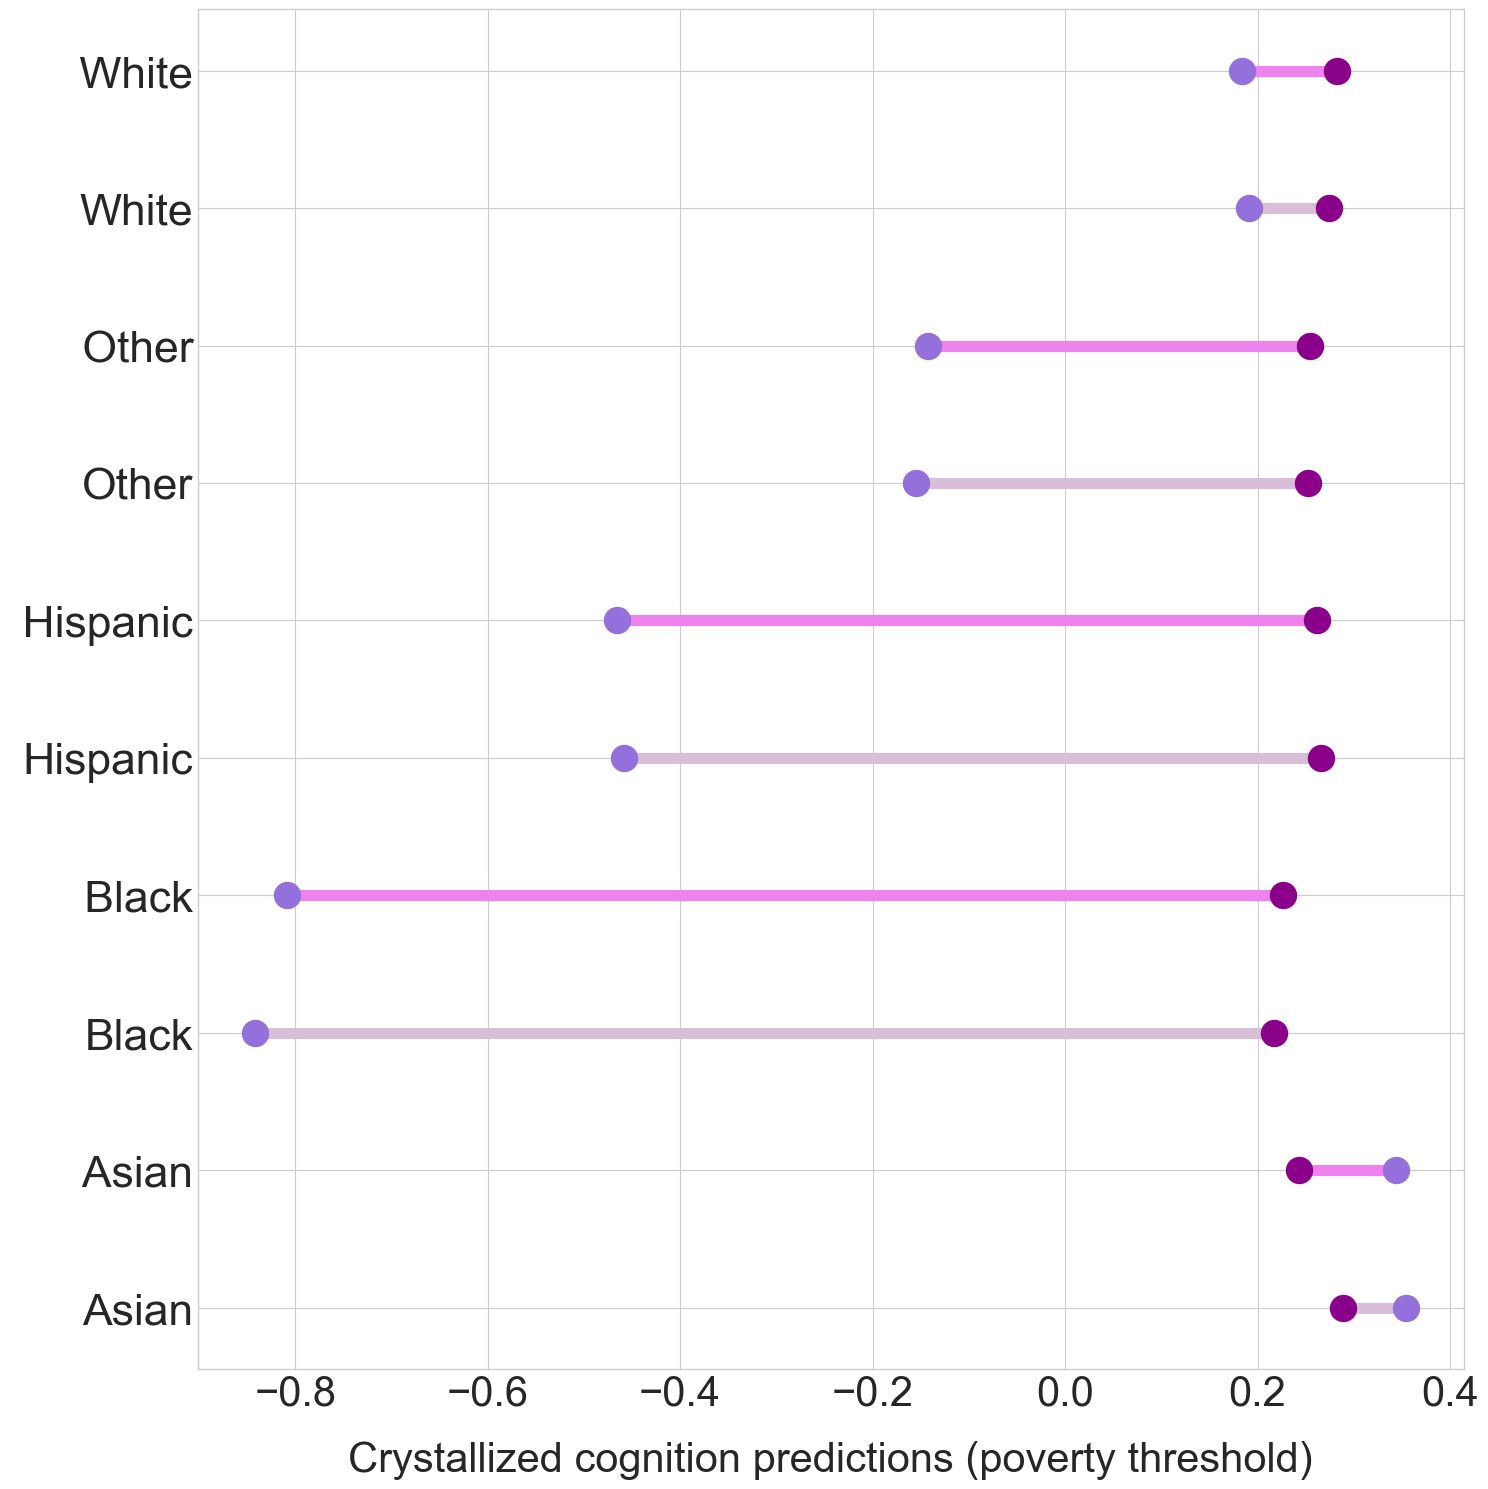

In [62]:
datas_r=mean_predictions_race
datas_r2=mean_predictions_race_ps
race_names = ['Asian',
 'Black',
 'Hispanic',
 'Other',
 'White']
#dont forget the blank space in front of the name so not overwritten
race_names2 = [' Asian',
 ' Black',
 ' Hispanic',
 ' Other',
 ' White']
# Plotting
plt.figure(figsize=(15, 15))

# Transpose the data matrix to iterate over states
for race_name, race_values,race_name2, race_values2 in zip(race_names, np.array(datas_r).T,race_names2, np.array(datas_r2).T):
    plt.plot(race_values, [race_name, race_name], 'k-',color='thistle', linewidth=8,zorder=1,label='before PS')  # Connect the points for the state
    plt.plot(race_values2, [race_name2, race_name2], 'k-',color='violet', linewidth=8,zorder=1,label='after PS')  # Connect the points for the state
    
    plt.scatter(race_values[0], race_name, color='darkmagenta', label='low pov oc', s=350,zorder=2)  # Plot value 1 for the state
    plt.scatter(race_values[1], race_name, color='mediumpurple', label='high pov oc', s=350,zorder=2)  # Plot value 2 for the state
    
    plt.scatter(race_values2[0], race_name2, color='darkmagenta', s=350,zorder=2)  # Plot value 1 for the state
    plt.scatter(race_values2[1], race_name2, color='mediumpurple', s=350,zorder=2)  # Plot value 2 for the state
    
plt.xticks(size=30)
plt.yticks(size=32)
plt.xlabel('Crystallized cognition predictions (poverty threshold)',size= 30,labelpad=20)
#plt.ylabel('States',size=25)
#plt.title('Values for Each Race')
#plt.legend(['before PS','after PS','low pov oc', 'high pov oc'],loc='upper right', bbox_to_anchor=(1.5, 1.0),frameon=True)
plt.grid(True)
plt.tight_layout()
plt.savefig('lolli_plot_pov_thresh_crystallized_ps_race_cognition_results_f5.svg',transparent=True,dpi=600, bbox_inches='tight',format='svg')
plt.show()